## Murt Sayeed (final version)

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/spring2021/comp135/home).

### Import required libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(ytrue_N.size):
        if ytrue_N[i] == 1:
            if yhat_N[i] == 1:
                TP += 1
            else:
                FN += 1
        else:
            if yhat_N[i] == 0:
                TN += 1
            else:
                FP += 1
    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [10]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [11]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [12]:
print("Fraction with cancer in TRAIN: %.3f" % (y_tr_M.sum()/y_tr_M.size)) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % (y_va_N.sum()/y_va_N.size))
print("Fraction with cancer in TEST : %.3f" % (y_te_N.sum()/y_te_N.size))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [13]:
def computeAccuracy(data=None,baseline=None):
    TP, TN, FP, FN = calc_TP_TN_FP_FN(data,baseline)
    return float((TP + TN)/(TP+TN+FP+FN))

valid_all_zero = np.zeros(len(y_va_N))
valid_accuracy = computeAccuracy(y_va_N,valid_all_zero)

test_all_zero = np.zeros(len(y_te_N))
test_accuracy = computeAccuracy(y_te_N,test_all_zero)

In [14]:
print("Always-0: accuracy on VALID: %.3f" % valid_accuracy) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % test_accuracy)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [15]:
# TODO call print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_va_N,valid_all_zero,0.5))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: The always-0 classifier has a reasonable accuracy at 86%. Out of 180 labels, 155 have accurately been classfied with predicted cancer output of '0'; but on the other side, 25 out of 180 are False Negative (it should be Positive). We have to focus on the group of data that has cancer versus that does not have cancer and always-0 classifier lacks predicted true cases to calculate Positive Predictive value (that we should pay attention) with the help of True Positive value and False Positive value. The always-0 classifier make only false negative classifications and not the true positive classifications, meaning this can only be treated as a baseline instead of a good case classifier. A doctor will not be able to use this, since it would not predict occurence of cancer based on any combination of features in the input data; and obviously cancer is still there in the population.

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: There are few weakness to always-0 classifier. Another error (addition to above), is when a patient who has been labelled "not" cancer from this model, resulted from predicting a false negative. The model fails to predict cases of cancer without biopsy, which is very poor outcome eventhough the accuracy rate is high. The accuracuy rate here is going against our conclusion of predicting cancer patients. This could have huge cost of a person dying and no one can recover from cost of life. The cost of time and money being work on this model given its unefficinecies, but the most important is time for an individual who had cancer and went untreated for a long time. Another cost that does not get priroity is emotional/mental sickness for the patient (wrongly diagonised or not) and their family/friends. This could also lead to malpractice at doctors clinic for possible lawsuits on using a flawed model. The most important outcome to remember from this model is the wrongly classficiation of patients, its not about correct prediction of patients who do not have cancel regardless of the model outcome. Therefore, we should try to minimize using this model or not use it at all, until we can fix the issue and reduce the associated cost mentioned above.

### 4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [16]:
tr_loss_list_2 = list()
va_loss_list_2 = list()

# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
def loss_detection(C,x_tr,y_tr,x_va,y_va):
    LRM = LogReg (C=C,solver='liblinear').fit(x_tr, y_tr)
    pred_tr = LRM.predict_proba(x_tr)
    pred_va = LRM.predict_proba(x_va)
    return sklearn.metrics.log_loss(y_tr,pred_tr),sklearn.metrics.log_loss(y_va,pred_va)

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    tr_loss,va_loss = loss_detection(C,x_tr_M2,y_tr_M,x_va_N2,y_va_N)
    tr_loss_list_2.append(tr_loss)
    va_loss_list_2.append(va_loss)

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

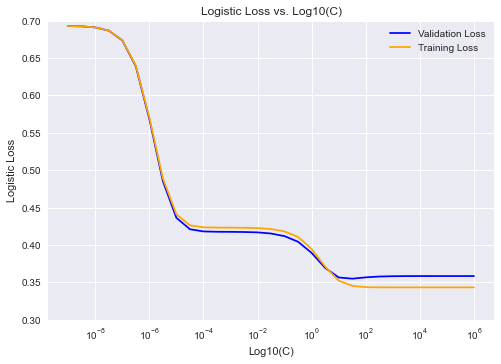

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [17]:
# TODO make plot
plt.xscale('log')
plt.xlabel('Log10(C)');
plt.ylabel('Logistic Loss');
plt.ylim([0.3, 0.7]);
plt.plot(C_grid,va_loss_list_2, color='blue',label = "Validation Loss")
plt.plot(C_grid,tr_loss_list_2, color='orange',label = "Training Loss")
plt.title('Logistic Loss vs. Log10(C)')

# TODO add legend
# plt.legend(...);
plt.legend()
plt.show()

print("Best C-value for LR with 2-feature data: %.3f" % C_grid[np.argmin(va_loss_list_2)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list_2))

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

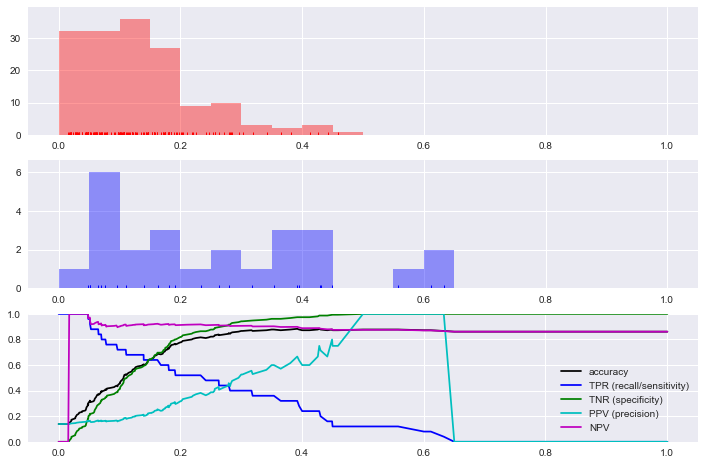

In [18]:
# TODO call make_plot_perf_vs_threshold(...)
best_2 = C_grid[np.argmin(va_loss_list_2)]
LRM = LogReg(C=best_2,solver='liblinear').fit(x_tr_M2, y_tr_M)
yproba = LRM.predict_proba(x_va_N2)[:,1]
make_plot_perf_vs_threshold(y_va_N, yproba)

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [19]:
# TODO like 1.4 (a), but with 3 features
tr_loss_list_3 = list()
va_loss_list_3 = list()

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    tr_loss,va_loss = loss_detection(C,x_tr_M3,y_tr_M,x_va_N3,y_va_N)
    tr_loss_list_3.append(tr_loss)
    va_loss_list_3.append(va_loss)

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

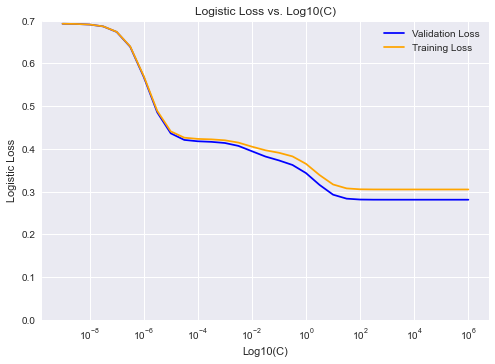

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


In [20]:
# TODO make plot
plt.xscale('log')
plt.xlabel('Log10(C)');
plt.ylabel('Logistic Loss');
plt.ylim([0.0, 0.7]);
plt.plot(C_grid,va_loss_list_3, color='blue',label = "Validation Loss")
plt.plot(C_grid,tr_loss_list_3, color='orange',label = "Training Loss")
plt.title('Logistic Loss vs. Log10(C)')

# TODO add legend
# plt.legend(...);
plt.legend()
plt.show()
print("Best C-value for LR with 3-feature data: %.3f" % C_grid[np.argmin(va_loss_list_3)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list_3))

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

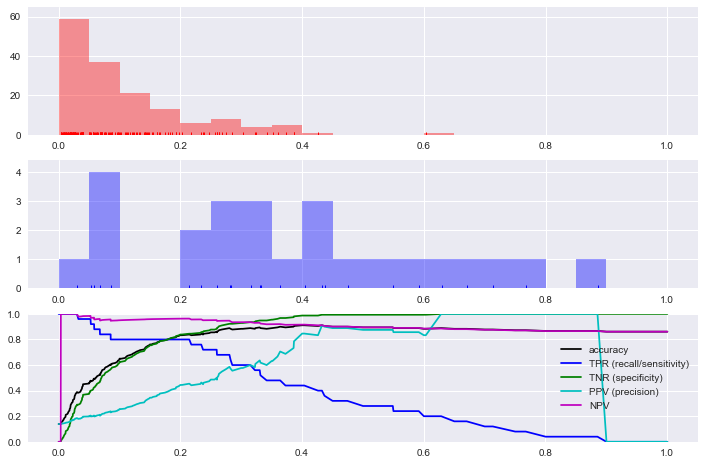

In [21]:
# TODO call make_plot_perf_vs_threshold(...)
best_3 = C_grid[np.argmin(va_loss_list_3)]
LRM = LogReg(C=best_3,solver='liblinear').fit(x_tr_M3, y_tr_M)
yproba = LRM.predict_proba(x_va_N3)[:,1]

make_plot_perf_vs_threshold(y_va_N, yproba)

### 5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

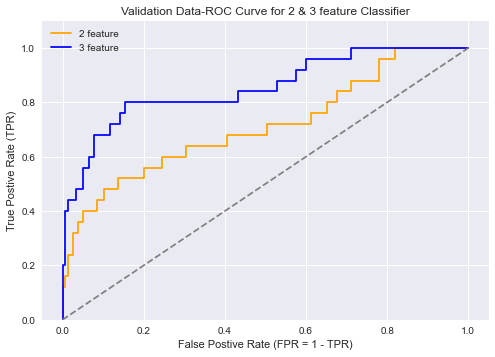

In [22]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)
LRM = LogReg(C=best_2,solver='liblinear').fit(x_tr_M2, y_tr_M)
yproba_va_2 = LRM.predict_proba(x_va_N2)[:,1]
LRM = LogReg(C=best_3,solver='liblinear').fit(x_tr_M3, y_tr_M)
yproba_va_3 = LRM.predict_proba(x_va_N3)[:,1]
fpr_va_2, tpr_va_2, thresholds_va_2 = sklearn.metrics.roc_curve(y_va_N, yproba_va_2)
fpr_va_3, tpr_va_3, thresholds_va_3 = sklearn.metrics.roc_curve(y_va_N, yproba_va_3)

plt.plot(fpr_va_2, tpr_va_2, c='orange', label = "2 feature");
plt.plot(fpr_va_3, tpr_va_3, c='blue', label = "3 feature");
plt.plot([0,1],[0,1], c='gray', linestyle='dashed')
plt.legend()

plt.ylim([0, 1.1]);
plt.xlabel("False Postive Rate (FPR = 1 - TPR)");
plt.ylabel("True Postive Rate (TPR)");

plt.title('Validation Data-ROC Curve for 2 & 3 feature Classifier');

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

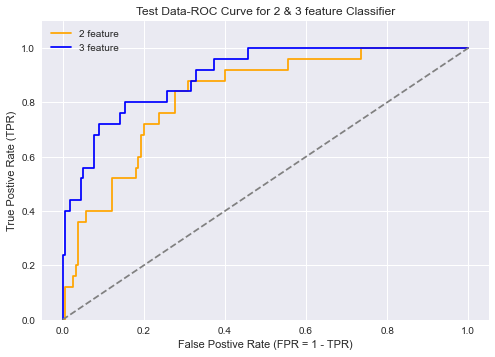

In [23]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)
LRM = LogReg(C=best_2,solver='liblinear').fit(x_tr_M2, y_tr_M)
yproba_te_2 = LRM.predict_proba(x_te_N2)[:,1]
LRM = LogReg(C=best_3,solver='liblinear').fit(x_tr_M3, y_tr_M)
yproba_te_3 = LRM.predict_proba(x_te_N3)[:,1]
fpr_te_2, tpr_te_2, thresholds_te_2 = sklearn.metrics.roc_curve(y_te_N, yproba_te_2)
fpr_te_3, tpr_te_3, thresholds_te_3 = sklearn.metrics.roc_curve(y_te_N, yproba_te_3)

plt.plot(fpr_te_2, tpr_te_2, c='orange', label = "2 feature");
plt.plot(fpr_te_3, tpr_te_3, c='blue', label = "3 feature");
plt.plot([0,1],[0,1],c='gray',linestyle='dashed')
plt.legend()
plt.ylim([0, 1.1]);
plt.xlabel("False Postive Rate (FPR = 1 - TPR)");
plt.ylabel("True Postive Rate (TPR)");

plt.title('Test Data-ROC Curve for 2 & 3 feature Classifier');

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: By definition, area under the ROC should be as large as possible. If we were to imagine a dotted/dashed diagonal line from (0,0) to (1,1); that would be the lowest possible area under the ROC, anything above this dotted/dashed imagionally line will be better. Looking at both plots (Validation & Test), both have actual 2-features (in 'orange') and 3-features (in 'blue') lines above this imagionally dotted/dashed line, which is good news. If we had an ideal classifier line, it would be from (0,0) to (0,1); resulting in accurate model with no false positives for each true negative. It seems the 3-features line is above the 2-features line, meaning more area under 3-features compare to 2-features. This helps draw inference from clinics/doctors work that having 3-features improves the model performance, which helps answer the question that there 3-features predict the true labels more accurately when cancer is present. The 3-features input set in both plots (Validation & Test) accepts less false positives for each true positive, resulting in higher input set and outperforms than the 2-features. When we compare the two plots to each other, Test plot performace in 2-features and 3-features are better than Validation plot; again due to higher area. The Test data set in both features has better performance (larger area) because it is used to confirm our model accuracy/performance. On the other hand, the Validation data set is used to correct Test data for any and all inconsistencies, such as overfitting.


### 6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [24]:
best_thr = 0.5

ypred_te_3 = LRM.predict(x_te_N3)

print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")

# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N,ypred_te_3,best_thr))

print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print_perf_metrics_for_threshold(y_te_N,ypred_te_3,best_thr)

Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [25]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
LRM = LogReg(C=best_3,solver='liblinear').fit(x_tr_M3, y_tr_M)
yproba_va_3 = LRM.predict_proba(x_va_N3)[:,1]
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yproba_va_3, thresh_grid=None)
yproba_te_3 = LRM.predict_proba(x_te_N3)[:,1]

# TODO Find threshold that makes validation set TPR as large as possible, 
# while satisfying PPV >= 0.98
def bestSatisfiedTPR(perf_grid,ppv):
    tmp = perf_grid['tpr'].copy()
    if (max(perf_grid['ppv']) < ppv):
        return
    while True:
        index = np.argmax(tmp)
        if perf_grid['ppv'][index] >= ppv:
            return index
        else:
            tmp[index] = 0
best_thr_index = bestSatisfiedTPR(perf_grid, 0.98)
best_thr = thresh_grid[best_thr_index]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) # TODO
print("")
print("ON THE TEST SET:")

# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N,yproba_te_3,best_thr))
print("")

# TODO: print(print_perf_metrics_for_threshold(...))
print_perf_metrics_for_threshold(y_te_N, yproba_te_3, best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [28]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
LRM = LogReg(C=best_3,solver='liblinear').fit(x_tr_M3, y_tr_M)
yproba_va_3 = LRM.predict_proba(x_va_N3)[:,1]
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yproba_va_3)
yproba_te_3 = LRM.predict_proba(x_te_N3)[:,1]

# TODO Find threshold that makes validation set PPV as large as possible, 
# while satisfying TPR >= 0.98
def bestSatisfiedPPV(perf_grid,tpr):
    if (max(perf_grid['tpr']) < tpr):
        print ("no threshold satisfied!")
        return
    tmp = perf_grid['ppv'].copy()
    while True:
        index = np.argmax(tmp)
        if perf_grid['tpr'][index] >= tpr:
            return index
        else:
            tmp[index] = 0         
best_thr_index = bestSatisfiedPPV(perf_grid, 0.98)
best_thr = thresh_grid[best_thr_index]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) # TODO
print("")
print("ON THE TEST SET:")

# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N,yproba_te_3,best_thr))
print("")

# TODO: print(print_perf_metrics_for_threshold(...))
print_perf_metrics_for_threshold(y_te_N, yproba_te_3, best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: There is no one confusion matrics that stands out from all three that illustrate the best performance. We will have to look at False Positive rate and False Negative rate. The most important cost in above three cases is False Negative rate, where a person is expected to not have cancer by the model but in reality he/she has cancer. This value must be low to avoid 'human' cost, while False Positive can and should also be low as a seconday measure to avoid extra operations headaches in biopsies. We should use the third case threshold of 0.03 where PPV was maximized and TPR >=0.98. By using third case, we have False Negative rate of 0 (1-TPR) and False Positive rate of 0.632 (1-TNR). 

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: Given above criteria holds true where False Negative is most important metric for us based on saving human life. Then, 57 biopsies could have been avoided where the 57 people were predicted to be in not have cancer by our model. We could have saved 32% (57/180) of biopsies.